# SVR Test Inference

Notebook dùng để load các mô hình SVR (.pkl) đã huấn luyện và đánh giá trực tiếp trên toàn bộ tập test (không rolling horizon). Mục tiêu là đo thời gian dự đoán một lượt và tính nhanh các metric (MAE, RMSE, MAPE, R²) cho từng target.


In [18]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model_utils import (
    load_model,
    get_latest_model,
    calculate_metrics,
    print_metrics,
)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f"{x:,.6f}")

print("✓ Libraries imported")


✓ Libraries imported


In [19]:
# Paths & targets
MODELS_DIR = Path('models')
DATA_DIR = Path('processed_data')
TARGETS = ['memory_usage_pct', 'cpu_total_usage', 'system_load']

MODELS_DIR.mkdir(exist_ok=True)

print("Configuration ready")


Configuration ready


In [20]:
def load_test_data(target: str):
    """Load X_test và y_test cho target cho sẵn."""
    target_dir = DATA_DIR / target
    X_test = pd.read_csv(target_dir / 'X_test.csv')
    y_test = pd.read_csv(target_dir / 'y_test.csv').squeeze()
    return X_test, y_test


def resolve_model_paths(model_name: str = 'svr'):
    """Lấy đường dẫn model mới nhất cho từng target."""
    model_paths = {}
    for target in TARGETS:
        model_paths[target] = get_latest_model(
            models_dir=str(MODELS_DIR),
            model_name=model_name,
            target=target,
        )
    return model_paths


model_paths = resolve_model_paths()
model_paths


Latest model: models\svr_memory_usage_pct_20251111_184735.pkl
Latest model: models\svr_cpu_total_usage_20251111_203645.pkl
Latest model: models\svr_system_load_20251111_223919.pkl


{'memory_usage_pct': 'models\\svr_memory_usage_pct_20251111_184735.pkl',
 'cpu_total_usage': 'models\\svr_cpu_total_usage_20251111_203645.pkl',
 'system_load': 'models\\svr_system_load_20251111_223919.pkl'}

In [21]:
evaluation_records = []
detailed_results = {}
prediction_store = {}
evaluation_results = {}

for target in TARGETS:
    print("\n" + "=" * 80)
    print(f"Target: {target}")
    print("=" * 80)

    X_test, y_test = load_test_data(target)
    model_path = model_paths[target]
    model, metadata = load_model(model_path)

    start_time = time.time()
    y_pred = model.predict(X_test)
    runtime = time.time() - start_time
    per_sample_ms = runtime / len(y_test) * 1000

    metrics = calculate_metrics(y_test.values, y_pred)
    print_metrics(metrics, target)
    print(f"  Runtime: {runtime:.2f}s ({per_sample_ms:.3f} ms/sample)")

    evaluation_records.append({
        'target': target,
        'model_path': model_path,
        'samples': len(y_test),
        'runtime_s': runtime,
        'ms_per_sample': per_sample_ms,
        **metrics,
    })

    detailed_results[target] = {
        'model_path': model_path,
        'metadata': metadata,
        'samples': len(y_test),
        'runtime_seconds': runtime,
        'ms_per_sample': per_sample_ms,
        'metrics': metrics,
    }

    prediction_store[target] = {
        'y_true': y_test.values,
        'y_pred': y_pred,
    }

    evaluation_results[target] = metrics

print("\n✓ Evaluation finished")



Target: memory_usage_pct
✓ Model loaded: models\svr_memory_usage_pct_20251111_184735.pkl
  Model: svr
  Target: memory_usage_pct
  Saved at: 2025-11-11 18:47:35

Metrics for memory_usage_pct:
  MAE:         0.416941
  RMSE:        0.547361
  MAPE:        143.18%
  R²:          0.617338
  Max Error:   5.737465
  Median AE:   0.329312
  Runtime: 112.59s (6.565 ms/sample)

Target: cpu_total_usage
✓ Model loaded: models\svr_cpu_total_usage_20251111_203645.pkl
  Model: svr
  Target: cpu_total_usage
  Saved at: 2025-11-11 20:36:45

Metrics for cpu_total_usage:
  MAE:         0.193895
  RMSE:        0.505259
  MAPE:        68.16%
  R²:          0.733078
  Max Error:   11.357502
  Median AE:   0.074404
  Runtime: 33.86s (1.974 ms/sample)

Target: system_load
✓ Model loaded: models\svr_system_load_20251111_223919.pkl
  Model: svr
  Target: system_load
  Saved at: 2025-11-11 22:39:19

Metrics for system_load:
  MAE:         0.268074
  RMSE:        0.478303
  MAPE:        452.80%
  R²:          

In [22]:
summary_df = pd.DataFrame(evaluation_records).set_index('target')
summary_df


,model_path,samples,runtime_s,ms_per_sample,mae,rmse,mse,mape,r2,max_error,median_ae
target,,,,,,,,,,,
memory_usage_pct,models\svr_memory_usage_pct_20251111_184735.pkl,17150,112.588451,6.564924,0.416941,0.547361,0.299604,143.178090,0.617338,5.737465,0.329312
cpu_total_usage,models\svr_cpu_total_usage_20251111_203645.pkl,17150,33.861511,1.974432,0.193895,0.505259,0.255287,68.155849,0.733078,11.357502,0.074404
system_load,models\svr_system_load_20251111_223919.pkl,17150,101.877992,5.940408,0.268074,0.478303,0.228774,452.801162,0.761410,6.267460,0.140984


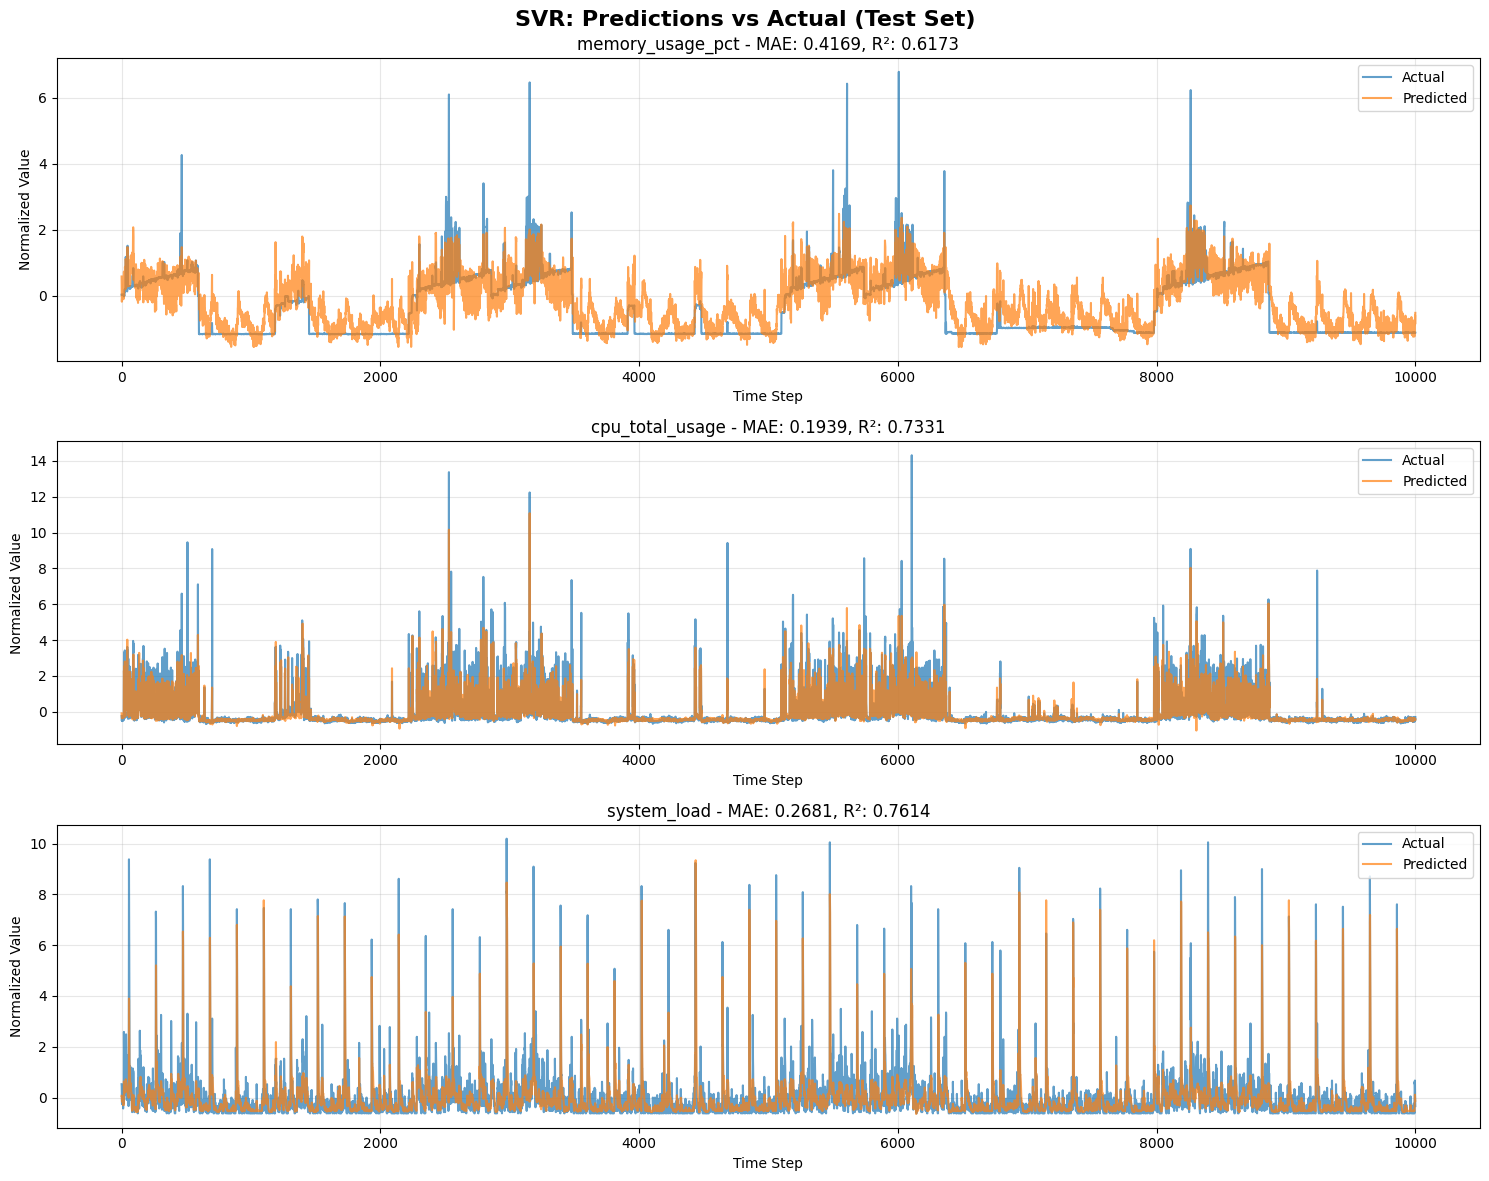

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('SVR: Predictions vs Actual (Test Set)', fontsize=16, fontweight='bold')

for idx, target in enumerate(TARGETS):
    if target not in prediction_store:
        axes[idx].set_visible(False)
        continue

    y_true = prediction_store[target]['y_true']
    y_pred = prediction_store[target]['y_pred']

    n_plot = min(10000, len(y_true))
    axes[idx].plot(y_true[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
    axes[idx].plot(y_pred[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
    axes[idx].set_title(
        f"{target} - MAE: {evaluation_results[target]['mae']:.4f}, "
        f"R²: {evaluation_results[target]['r2']:.4f}"
    )
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Normalized Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


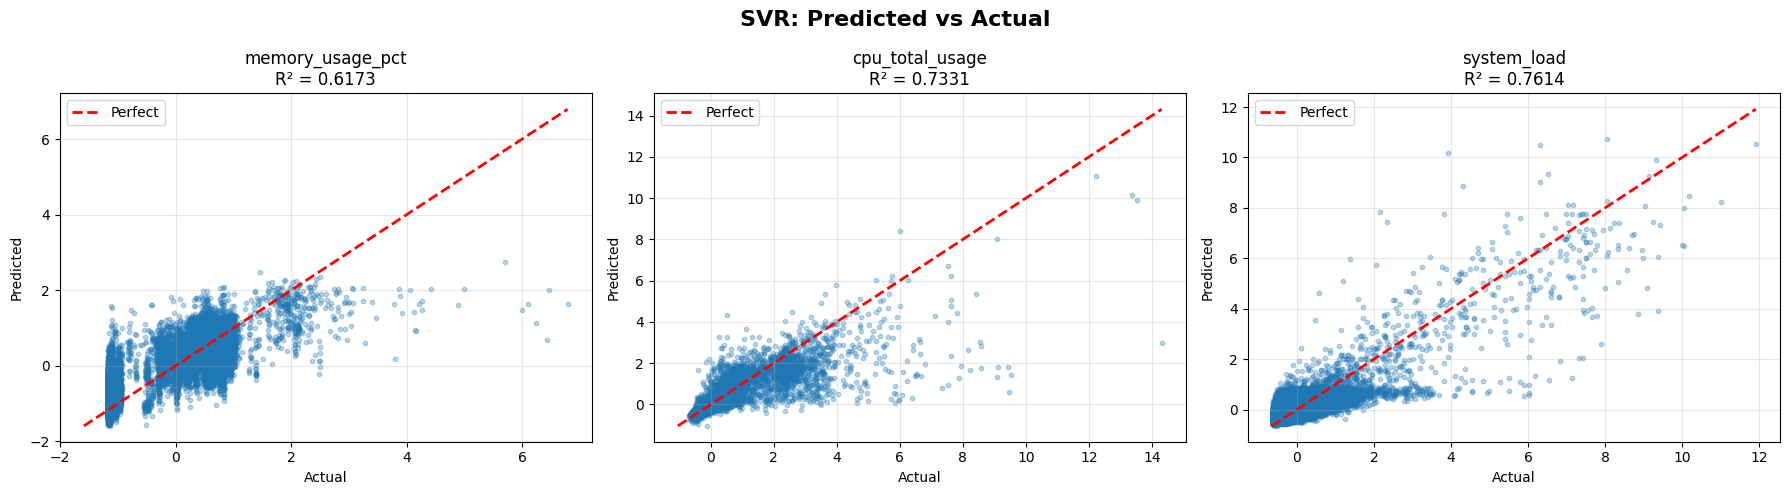

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('SVR: Predicted vs Actual', fontsize=16, fontweight='bold')

for idx, target in enumerate(TARGETS):
    if target not in prediction_store:
        axes[idx].set_visible(False)
        continue

    y_true = prediction_store[target]['y_true']
    y_pred = prediction_store[target]['y_pred']

    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')

    axes[idx].set_title(f"{target}\nR² = {evaluation_results[target]['r2']:.4f}")
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


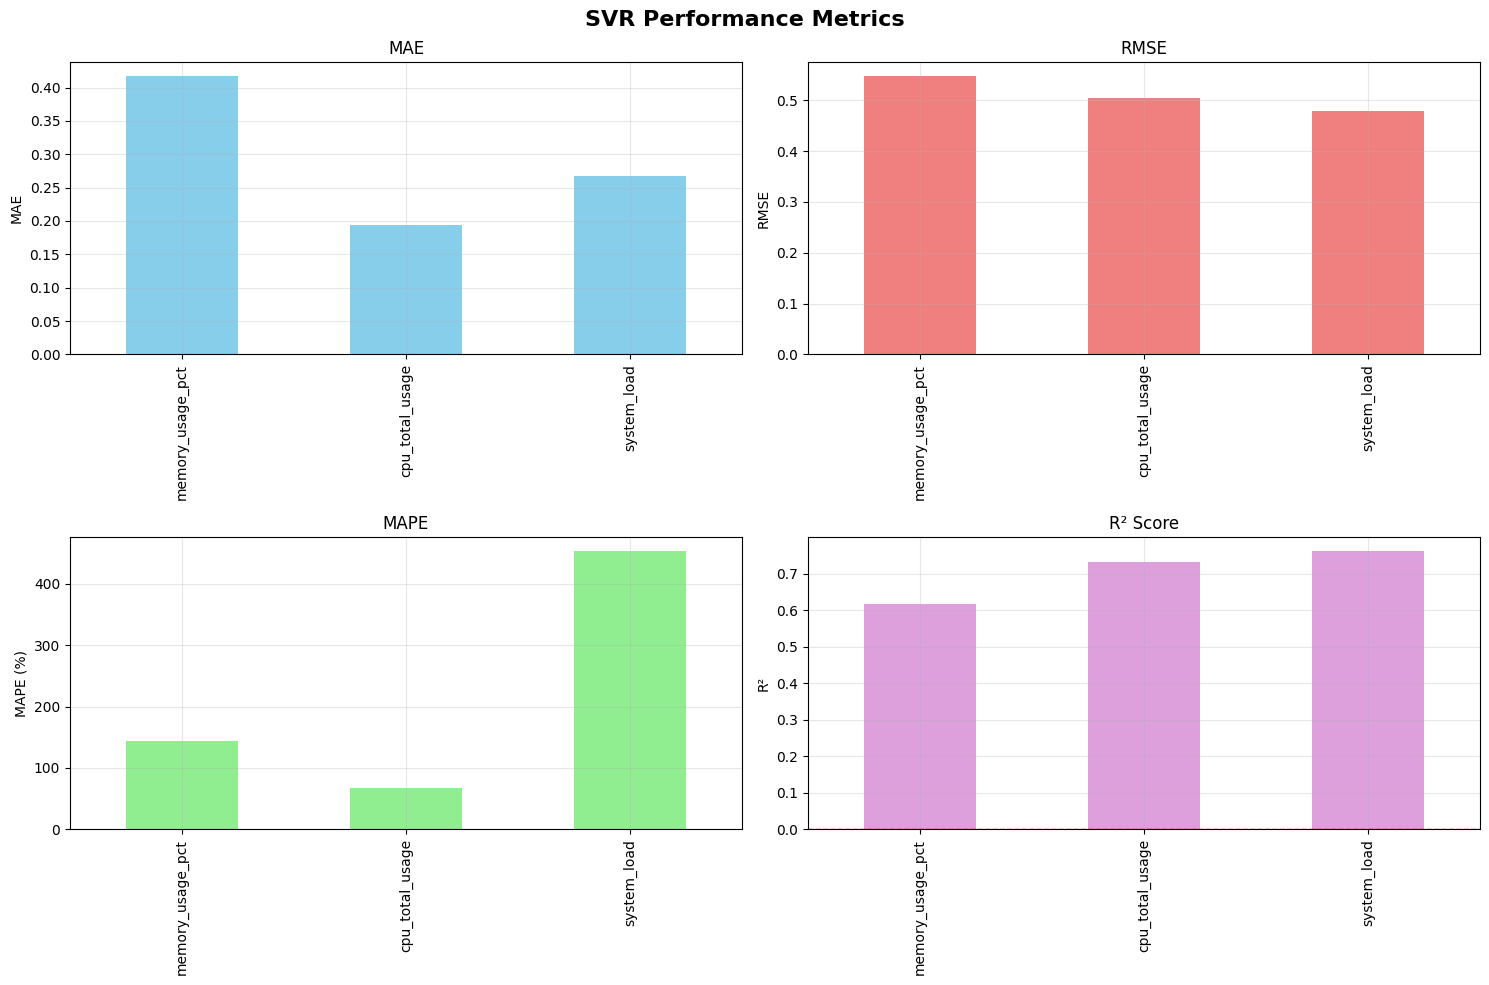

In [25]:
metrics_df = pd.DataFrame(evaluation_results).T

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SVR Performance Metrics', fontsize=16, fontweight='bold')

metrics_df['mae'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('MAE')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True, alpha=0.3)

metrics_df['rmse'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('RMSE')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True, alpha=0.3)

metrics_df['mape'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('MAPE')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

metrics_df['r2'].plot(kind='bar', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R²')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# (Optional) lưu nhanh kết quả sang JSON
from model_utils import save_results

results_payload = {
    'model': 'svr',
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'targets': detailed_results,
}

save_results(results_payload, 'results_svr_inference_test.json')


✓ Results saved: results_svr_inference_test.json


'results_svr_inference_test.json'